Join the data from Part 1 with the data from Part 2 to create a new dataframe.

In [23]:
import pandas as pd

philly = pd.read_csv("../data/philly.csv")
if "Unnamed: 0" in philly.columns:
    philly = philly.drop(columns=["Unnamed: 0"])
philly = philly.reset_index(drop=True)

fs_phi_poi_clean = pd.read_csv("../data/fs_phi_poi_clean.csv")
if "Unnamed: 0" in fs_phi_poi_clean.columns:
    fs_phi_poi_clean = fs_phi_poi_clean.drop(columns=["Unnamed: 0"])
fs_phi_poi_clean = fs_phi_poi_clean.reset_index(drop=True)

yp_phi_poi_clean = pd.read_csv("../data/yp_phi_poi_clean.csv", index_col=0)
if "Unnamed: 0" in yp_phi_poi_clean.columns:
    yp_phi_poi_clean = yp_phi_poi_clean.drop(columns=["Unnamed: 0"])
yp_phi_poi_clean = yp_phi_poi_clean.reset_index(drop=True)

## realized a new column had been created with the old Index numbers, just getting rid of it ^

fs_phi_poi_clean["source"] = "Foursquare"
yp_phi_poi_clean["source"] = "Yelp"

## in case I want to compare Foursquare vs Yelp, added an additional column to keep the source of the info available

fs_phi_poi_clean = fs_phi_poi_clean.rename(columns={"distance_m": "distance_to"})
fs_phi_poi_clean = fs_phi_poi_clean.rename(columns={"poi_name": "name"})
philly = philly.rename(columns={"name": "station_name"})

## readjusting due to lack of forethought apparently

all_columns = set(fs_phi_poi_clean.columns).union(set(yp_phi_poi_clean.columns))

fs_phi_poi_clean = fs_phi_poi_clean.reindex(columns=all_columns)
yp_phi_poi_clean = yp_phi_poi_clean.reindex(columns=all_columns)

yelp_w_fs = pd.concat([fs_phi_poi_clean, yp_phi_poi_clean], ignore_index=True)

In [64]:
full_combined = yelp_w_fs.merge(philly, on="station_name", how="left")
full_combined = full_combined.rename(columns={
    "latitude_x": "poi_latitude",
    "longitude_x": "poi_longitude",
    "latitude_y": "station_latitude",
    "longitude_y": "station_longitude"
})

full_combined_sorted = full_combined.sort_values(by="source", ascending=False)
full_combined_clean = full_combined_sorted.drop_duplicates(subset=["name", "poi_latitude", "poi_longitude"], keep="first")

In [65]:
full_combined_clean.to_csv("combined_all.csv")

Provide a visualization that you used as part of your EDA process. Explain the initial pattern or relationship you discoved through this visualization. 

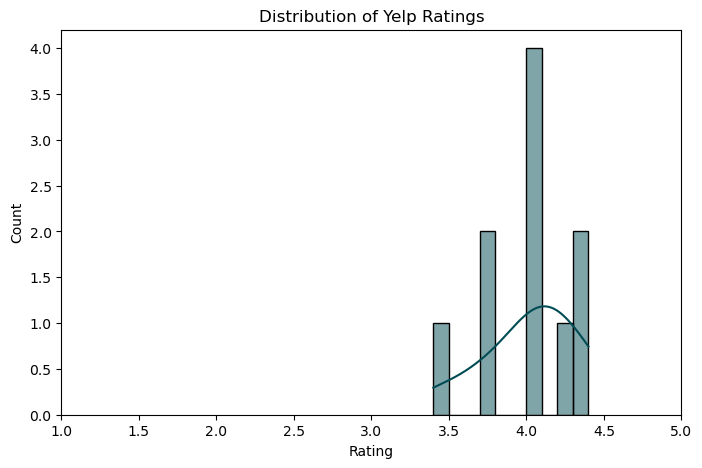

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(data=full_combined[full_combined["source"] == "Yelp"], x="rating", bins=10, kde=True, color="#004C54")
plt.title("Distribution of Yelp Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.xlim(1,5)
plt.show()

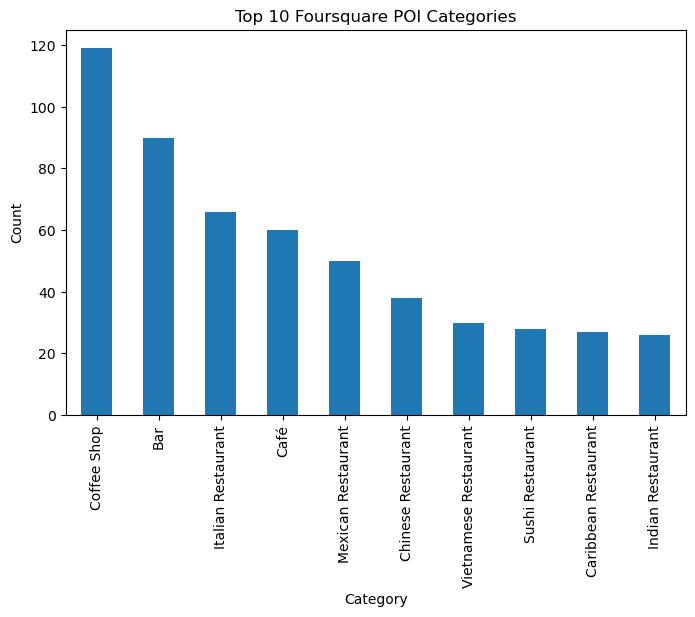

In [67]:
fs_phi_poi_clean["category"].value_counts().head(10).plot(kind="bar", figsize=(8,5))
plt.title("Top 10 Foursquare POI Categories")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

In [60]:
poi_per_station = full_combined_clean.groupby("station_name").size().reset_index(name="poi_count")
bike_counts = philly[["station_name", "num_bikes"]]
station_summary = pd.merge(poi_per_station, bike_counts, on="station_name", how="left")

In [68]:
station_summary.to_csv("station_summary.csv")

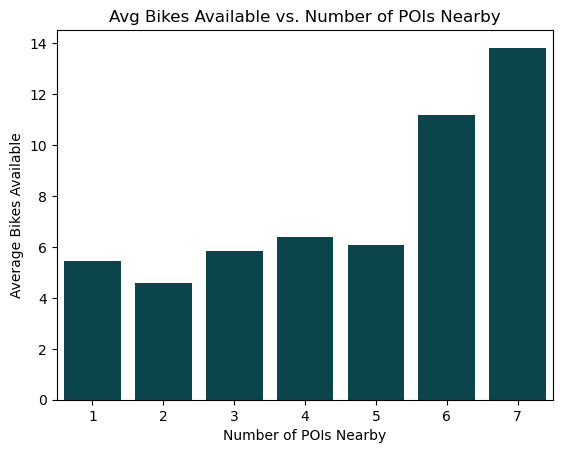

In [63]:
grouped = station_summary.groupby("poi_count")["num_bikes"].mean().reset_index()

sns.barplot(data=grouped, x="poi_count", y="num_bikes", color="#004C54")
plt.title("Avg Bikes Available vs. Number of POIs Nearby")
plt.xlabel("Number of POIs Nearby")
plt.ylabel("Average Bikes Available")
plt.show()

I wanted to explore whether station surroundings, both in terms of venue count and type, relate to user experience (Yelp ratings) or operational decisions (number of bikes available).

1.	Distribution of Yelp Ratings:
    Most businesses near bike stations are rated above 3.5. While this doesn’t directly confirm whether proximity to a station impacts quality, it offers a general sense of user satisfaction in these areas.

2.	Top 10 Foursquare POI Categories:
    This chart highlights the functional makeup of the areas surrounding bike stations, with a focus on food and beverage-related businesses. It helps contextualize what types of destinations riders may be traveling to or from.

3.	Average Bikes Available vs. Number of POIs Nearby:
    This visualization suggests a potential correlation between POI density and the number of bikes available. Stations surrounded by more points of interest tend to have higher average bike availability, which could reflect strategic stocking decisions in high-traffic zones.

# Database

Put all your results in an SQLite3 database (remember, SQLite stores its databases as files in your local machine - make sure to create your database in your project's data/ directory!)

In [75]:
philly = pd.read_csv("../data/philly.csv")
fs_phi_poi_clean = pd.read_csv("../data/fs_phi_poi_clean.csv")
fs_phi_poi_raw = pd.read_csv("../data/fs_phi_poi_raw.csv")
yp_phi_poi_clean = pd.read_csv("../data/yp_phi_poi_clean.csv")
yp_phi_poi_raw = pd.read_csv("../data/yp_phi_poi.csv")
combined_all = pd.read_csv("../data/combined_all.csv")
station_summary = pd.read_csv("../data/station_summary.csv")

In [82]:
import sqlite3

conn = sqlite3.connect("bike_station_analysis.db")

combined_all.to_sql("combined_all", conn, if_exists="replace", index=False)
station_summary.to_sql("station_summary", conn, if_exists="replace", index=False)
fs_phi_poi_clean.to_sql("foursquare_clean", conn, if_exists="replace", index=False)
fs_phi_poi_raw.to_sql("foursquare_raw", conn, if_exists="replace", index=False)
philly.to_sql("citybikes", conn, if_exists="replace", index=False)
yp_phi_poi_clean.to_sql("yelp_clean", conn, if_exists="replace", index=False)
yp_phi_poi_raw.to_sql("yelp_raw", conn, if_exists="replace", index=False)

cursor = conn.cursor()

Look at the data before and after the join to validate your data.